# In this notebook we will demonstrate how one can vectorise the density operator for efficient simulations using qutip

We can make use of a very powerful formalism to learn about the steadystate behaviour of our system. 
This system recasts the matrix behaviour of the Lindblad superoperators, and the density operator into a linear matrix equation.
The $2d\times2d$ density operator can be recast as a column vector where the columns of the density operator are stacked
\begin{equation}
    \hat{\rho} = 
    \left(
    \begin{array}{cc}
    a   &  b\\
    c   & d
    \end{array}
    \right)
    \rightarrow
    \mathrm{vec}(\hat{\rho}) = |{\rho}\rangle 
    = \left(
    \begin{array}{c}
        a  \\ c \\ b \\ d
    \end{array}\right)
    \,.
\end{equation}
This is equivalent to the Choi-Jamiolkowski Isomorphism 
\begin{equation}
    \hat{\rho} = \sum_{ij}p_{ij}|{i}\rangle \langle{j}| \rightarrow |{\rho}\rangle = \sum_{ij} p_{ij}|{j}\rangle \otimes |{i}\rangle\,.
\end{equation}
The product between operators can readily be defined as 
\begin{equation}
\label{eq:vecABC}
    \mathrm{vec}(ABC) = \left(C^{T} \otimes A\right) |{B}\rangle ,
\end{equation}
which will allow us to rewrite the superoperator $\mathcal{L}$ as a matrix $\hat{\mathcal{L}}$.
This is a very useful formalism since the inner product between operators can then be represented as
\begin{equation}
    tr[\hat{A}^{\dagger} \hat{B}] = \langle {A^{\dagger}} | {B} \rangle\,,
\end{equation}
and the trace operator is defined as the inner product with the identity, which for the density operator reads
\begin{equation}
    tr[\hat{\rho}] = \langle {I} | {\rho}\rangle = 1\,,
\end{equation}
where the identity is defined as
\begin{equation}
    |{I}\rangle  = \sum_{i} |{i} \rangle\otimes |{i}\rangle\,,
\end{equation}
which is the maximally entangled, unnormalised Bell state.

Let's now consider a simple example of the Lindblad master  where we will make use of the multiplication operator such that $\mathrm{vec}({\hat{H}\hat{\rho}}) = (I \otimes \hat{H}) |{\rho} \rangle$ and the unitary part becomes
\begin{equation}
    \mathrm{vec}\left(-i \left[\hat{H}, \hat{\rho}\right]\right) 
    =
    - i \left(I \otimes \hat{H} - \hat{H} \otimes I\right) |{\rho}\rangle \,.
\end{equation}
The dissipator becomes 
\begin{equation}
    \mathrm{vec}\left(\mathcal{D}[\hat{L}]\hat{\rho}\right) = 
    \left(\hat{L}^{*} \otimes \hat{L} - \frac{1}{2} I \otimes \hat{L}^{\dagger}\hat{L} + \frac{1}{2} (\hat{L}^{\dagger}\hat{L})^{T} \otimes I\right) |{\rho}\rangle
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 24})

Let's first consider a very simple example of an atom coupled to a bath and undergoing spontaneous emission subject to some coherent Rabi oscillations $\Omega \sigma_{x}$. The Lindblad for this system that is s

\begin{equation}
\frac{d \rho}{dt} = \gamma \mathcal{D}[\sigma_{-}]\rho
\end{equation}

We will start by defining the system operators required for this system

In [2]:
# System dimensions
N = 2
γ = 0.5
Ω = 2

# Initial state
ρ = fock_dm(N, 0)

# System operators
a = destroy(N)
σx = sigmax()
σz = sigmaz()
σy = sigmay()
nc = a.dag()*a
σm = sigmam()

# Collapse operators
c_ops = [np.sqrt(γ)*σm]
e_ops = [σz, σx]

# Hamiltonian
I = identity(N)
H0 = Ω*σx

# vectorise operators
σz_vec = operator_to_vector(σz).trans()

# Define times as 
t0, tM, dt = 0, 10, 0.01
t = np.arange(t0, tM, dt)
ts = np.arange(t0, tM, 0.5)

In [3]:
# We can now vectorise the density operator using the following function 
ρvec = operator_to_vector(ρ)

ρvec

Quantum object: dims = [[[2], [2]], [1]], shape = (4, 1), type = operator-ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

It is worth pausing for a second and defining a few superoperators that may be useful in qutip.
We can define the pre and post superoperators for an operator $A$ as
\begin{equation}
\mathrm{spre} = I \otimes A \quad \mathrm{spost} = A \otimes I \quad \mathrm{to\_super} = A^{*}\otimes A
\end{equation}
We will demonstrate this here using the $\sigma_{y}$ operator

In [4]:
to_super(σy) == Qobj(tensor(σy.conj(),σy), type='super')

True

In [5]:
spre(σy) == Qobj(tensor(I,σy), type='super')

True

In [6]:
spost(σy) == Qobj(tensor(σy.trans(),I), type='super')

True

We can make use of the Liouvillian function which will compute the superoperator of the Liouvillain for our Hamiltonian and collapse operators

In [7]:
# Compute Liouvillian
ℒ = liouvillian(H0, c_ops)

# Compute expectation value with using vectorize σz
σze = np.array([np.real((σz_vec*(ℒ*ti).expm()*ρvec)[0,0]) for ti in ts])

# Solve using master equation
result = mesolve(H0, ρ, t, c_ops=c_ops, e_ops=e_ops)

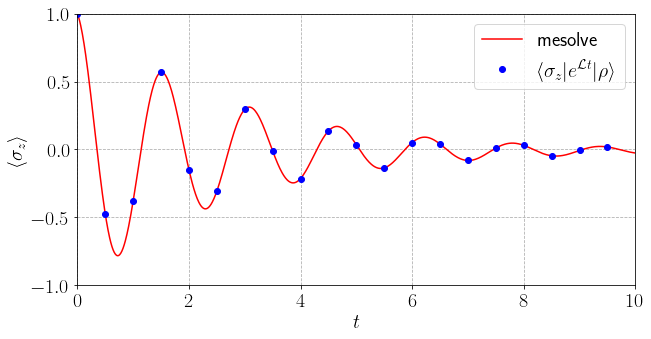

In [8]:
fs = 20

plt.figure(figsize=(10,5))
plt.plot(t, result.expect[0], 'r', label='mesolve')
plt.plot(ts, σze, 'bo', label=r'$\langle \sigma_{z} | e^{\mathcal{L}t} | \rho \rangle$')


plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim([t0, tM])
plt.ylim([-1,1])

plt.xlabel(r'$t$', fontsize=fs)
plt.ylabel(r'$\langle \sigma_{z} \rangle$', fontsize=fs)
plt.grid(linestyle='--')

plt.legend(fontsize=fs)
plt.show()